In [1]:
# from tensorflow.keras import mixed_precision

In [2]:
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [3]:
from helper_functions import  plot_loss_curves, create_tensorboard_callback, compare_historys

import tensorflow as tf

In [4]:
import tensorflow_datasets as tfds

ds = tfds.load('food101')


Metal device set to: Apple M1 Pro


2023-03-21 08:14:42.296123: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-21 08:14:42.296355: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
tfds.list_builders()

2023-03-21 08:14:42.404507: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'ble_wind_field',
 'blimp',
 'booksum',
 'bool_q',
 'bucc',
 'c4',
 'c4_wsrs',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar100_n',
 'cifar10_1',
 'cifar10_corrupted',
 'cifar10_n',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'conll2002',
 'conll2003',
 'controlled_noisy_web_labels'

In [6]:
(train_data, test_data), ds_info = tfds.load('food101', split=["train", "validation"], shuffle_files=True,
                                             with_info=True
                                            )

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
class_names = ds_info.features["label"].names

In [9]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
type(train_data)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [11]:
train_sample_one = train_data.take(1)
train_sample_one.as_numpy_iterator(), type(train_data)

2023-03-21 08:14:44.818722: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(<tensorflow.python.data.ops.dataset_ops._NumpyIterator at 0x293451550>,
 tensorflow.python.data.ops.dataset_ops.PrefetchDataset)

Text(0.5, 1.0, 'class: fried_calamari')

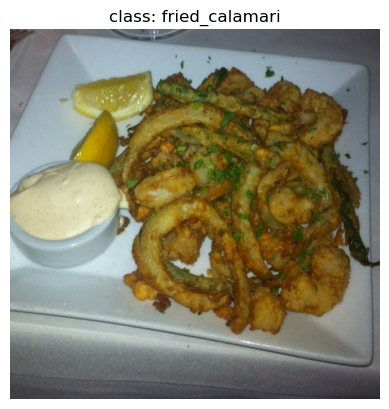

In [12]:
import matplotlib.pyplot as plt
sample = list(train_sample_one.as_numpy_iterator())[0]
image = sample['image']/255.
label = sample['label']


plt.axis(False)
plt.imshow(image)
plt.title(f"class: {class_names[label]}")


In [13]:


type(train_data)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

# Create pre processing functions

Current data is not
- different sizes
- not batched
- labels not one hot encoded
- uint8
- 0 to 255






In [14]:
def preprocess_image(sample, img_size=224):
    image = sample['image']
    label = sample['label']

    image = tf.image.resize(image, [img_size, img_size])
    # image = image/255 # not required for effienctnetBX
    return tf.cast(image, tf.float32), label

In [15]:
sample = list(train_sample_one.as_numpy_iterator())[0]

# print(image.shape)
# print(image.dtype)


preprocessed_image = preprocess_image(sample)
preprocessed_image[0].shape, preprocessed_image[0].dtype

(TensorShape([224, 224, 3]), tf.float32)

#  Optimize data pipeline

https://www.tensorflow.org/guide/data_performance

map preprocessing function to train data

In [16]:
train_data = train_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(10000)
train_data = train_data.batch(32)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

In [17]:
test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.shuffle(10000)
test_data = test_data.batch(32)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

In [18]:
train_data, test_data, len(train_data)

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 2368)

## Callbacks
-  tensorboard
- checkpoint


In [19]:
# tensorboard callback
from helper_functions import create_tensorboard_callback

# model checkpoint callback
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True,
                                                     save_weights_only=True, verbose=0)

## setup mixed precision

In [151]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

In [154]:
#  Model 1 using keras functional api without data augmentation

base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, # top is output layer we want to change it to 10 classes
    )
base_model.trainable = False

inputs =  tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# resnet50v2 needs rescaling, not for efficientnet as they have rescaling builtin 
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/.255)(inputs)

x = inputs
print(x.shape)

x = base_model(x, training=False)
print(x.shape)



#  average pooling our outputs from base model to get most important models.
x = tf.keras.layers.GlobalAveragePooling2D(name="gloable_average_pooling2d")(x)
x.shape

# output activation layers
outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')
model_1.summary()


# history_model_1 = model_1.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=test_data, 
#                        validation_steps=(0.25 * len(test_data)), callbacks=[model_checkpoint, create_tensorboard_callback(dir_name="tensorboard_hub_07", experiment_name="07_model_1")])

(None, 224, 224, 3)
(None, 7, 7, 1280)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 gloable_average_pooling2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________
Saving TensorBoard log files to: tensorboard_hub_07/07_model_1/2023032

Epoch 1/5


2023-03-20 20:19:17.912542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - ETA: 0s - loss: 1.7194 - accuracy: 0.5821

2023-03-20 20:23:36.568218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - 290s 118ms/step - loss: 1.7194 - accuracy: 0.5821 - val_loss: 1.0965 - val_accuracy: 0.7064
Epoch 2/5
2368/2368 [==============================] - 283s 117ms/step - loss: 1.1996 - accuracy: 0.6879 - val_loss: 1.0115 - val_accuracy: 0.7244
Epoch 3/5
2368/2368 [==============================] - 281s 117ms/step - loss: 1.0535 - accuracy: 0.7227 - val_loss: 0.9814 - val_accuracy: 0.7304
Epoch 4/5
2368/2368 [==============================] - 285s 118ms/step - loss: 0.9606 - accuracy: 0.7470 - val_loss: 0.9551 - val_accuracy: 0.7322
Epoch 5/5
2368/2368 [==============================] - 281s 116ms/step - loss: 0.8889 - accuracy: 0.7655 - val_loss: 0.9702 - val_accuracy: 0.7355


In [155]:
model_1.evaluate(test_data)

790/790 [==============================] - 84s 102ms/step - loss: 0.9766 - accuracy: 0.7356


[0.9765814542770386, 0.7355643510818481]

In [156]:
# model_1.save_weights("07_model_1")

In [170]:
base_model.trainable = False

for layer in base_model.layers[:-10]:
    layer.trainable = True
    print(layer_number, layer.name, layer.trainable)

237 input_2 True
237 rescaling_2 True
237 normalization_1 True
237 rescaling_3 True
237 stem_conv_pad True
237 stem_conv True
237 stem_bn True
237 stem_activation True
237 block1a_dwconv True
237 block1a_bn True
237 block1a_activation True
237 block1a_se_squeeze True
237 block1a_se_reshape True
237 block1a_se_reduce True
237 block1a_se_expand True
237 block1a_se_excite True
237 block1a_project_conv True
237 block1a_project_bn True
237 block2a_expand_conv True
237 block2a_expand_bn True
237 block2a_expand_activation True
237 block2a_dwconv_pad True
237 block2a_dwconv True
237 block2a_bn True
237 block2a_activation True
237 block2a_se_squeeze True
237 block2a_se_reshape True
237 block2a_se_reduce True
237 block2a_se_expand True
237 block2a_se_excite True
237 block2a_project_conv True
237 block2a_project_bn True
237 block2b_expand_conv True
237 block2b_expand_bn True
237 block2b_expand_activation True
237 block2b_dwconv True
237 block2b_bn True
237 block2b_activation True
237 block2b_se_s

In [158]:
model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics='accuracy')

In [160]:
history_model_2 = model_1.fit(train_data, epochs=10, steps_per_epoch=len(train_data), validation_data=test_data, 
                              initial_epoch=history_model_1.epoch[-1],
                              validation_steps=(0.25 * len(test_data)), 
                              callbacks=[create_tensorboard_callback(dir_name="tensorboard_hub_07", experiment_name="07_model_2")])

Saving TensorBoard log files to: tensorboard_hub_07/07_model_2/20230320-204744


Epoch 5/10


2023-03-20 20:47:49.158664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - ETA: 0s - loss: 0.7572 - accuracy: 0.8064

2023-03-20 20:51:36.152195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - 255s 103ms/step - loss: 0.7572 - accuracy: 0.8064 - val_loss: 0.9463 - val_accuracy: 0.7380
Epoch 6/10
2368/2368 [==============================] - 244s 101ms/step - loss: 0.7445 - accuracy: 0.8110 - val_loss: 0.9386 - val_accuracy: 0.7446
Epoch 7/10
2368/2368 [==============================] - 243s 101ms/step - loss: 0.7376 - accuracy: 0.8136 - val_loss: 0.9315 - val_accuracy: 0.7413
Epoch 8/10
2368/2368 [==============================] - 241s 100ms/step - loss: 0.7314 - accuracy: 0.8149 - val_loss: 0.9521 - val_accuracy: 0.7347
Epoch 9/10
2368/2368 [==============================] - 242s 100ms/step - loss: 0.7260 - accuracy: 0.8169 - val_loss: 0.9229 - val_accuracy: 0.7421
Epoch 10/10
2368/2368 [==============================] - 246s 102ms/step - loss: 0.7208 - accuracy: 0.8185 - val_loss: 0.9202 - val_accuracy: 0.7495


In [161]:
model_1.evaluate(test_data)

790/790 [==============================] - 74s 90ms/step - loss: 0.9417 - accuracy: 0.7435


[0.9416666626930237, 0.7435247898101807]

In [162]:
model_2 = tf.keras.models.clone_model(
    model_1
)
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 gloable_average_pooling2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 3,243,697
Non-trainable params: 935,255
_________________________________________________________________


In [163]:
model_2.load_weights("07_model_1")


In [165]:
model_2.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')
model_2.evaluate(test_data)

2023-03-20 21:14:29.450569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


790/790 [==============================] - 79s 91ms/step - loss: 1.3529 - accuracy: 0.6431


[1.352927803993225, 0.6430891156196594]

In [171]:
model_1.evaluate(test_data)

790/790 [==============================] - 74s 89ms/step - loss: 0.9417 - accuracy: 0.7435


[0.9416673183441162, 0.7435247898101807]

In [172]:
history_model_3 = model_1.fit(train_data, epochs=100, steps_per_epoch=len(train_data), validation_data=test_data, 
                              initial_epoch=history_model_2.epoch[-1],
                              validation_steps=(0.25 * len(test_data)), 
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,
                                                                          restore_best_weights=True),
                                         create_tensorboard_callback(dir_name="tensorboard_hub_07", experiment_name="07_model_3")])

Saving TensorBoard log files to: tensorboard_hub_07/07_model_3/20230320-212722


Epoch 10/100
2368/2368 [==============================] - 245s 101ms/step - loss: 0.7157 - accuracy: 0.8206 - val_loss: 0.9517 - val_accuracy: 0.7380
Epoch 11/100
2368/2368 [==============================] - 241s 100ms/step - loss: 0.7109 - accuracy: 0.8212 - val_loss: 0.9202 - val_accuracy: 0.7446
Epoch 12/100
2368/2368 [==============================] - 240s 100ms/step - loss: 0.7063 - accuracy: 0.8233 - val_loss: 0.9149 - val_accuracy: 0.7491
Epoch 13/100
2368/2368 [==============================] - 240s 99ms/step - loss: 0.7017 - accuracy: 0.8246 - val_loss: 0.9441 - val_accuracy: 0.7407
Epoch 14/100
2368/2368 [==============================] - 240s 99ms/step - loss: 0.6971 - accuracy: 0.8258 - val_loss: 0.9213 - val_accuracy: 0.7465
Epoch 15/100
2368/2368 [==============================] - 241s 100ms/step - loss: 0.6927 - accuracy: 0.8269 - val_loss: 0.9320 - val_accuracy: 0.7404


In [173]:
model_1.evaluate(test_data)


790/790 [==============================] - 73s 89ms/step - loss: 0.9427 - accuracy: 0.7425


[0.942714273929596, 0.742495059967041]

In [37]:
from tensorflow.keras.layers.experimental import preprocessing

data_agumentation =  tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal")
], name="data_agumentation")

In [38]:
#  Model 2 using keras functional api with data augmentation

base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, # top is output layer we want to change it to 10 classes
    )
base_model.trainable = False

inputs =  tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# resnet50v2 needs rescaling, not for efficientnet as they have rescaling builtin 
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/.255)(inputs)

x = data_agumentation(inputs)
print(x.shape)

x = base_model(x, training=False)
print(x.shape)



#  average pooling our outputs from base model to get most important models.
x = tf.keras.layers.GlobalAveragePooling2D(name="gloable_average_pooling2d")(x)
print(x.shape)

# output activation layers
outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')
model_2.summary()


history_model_2_1 = model_2.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=test_data, 
                       validation_steps=(0.25 * len(test_data)), callbacks=[tf.keras.callbacks.ModelCheckpoint("model_2_checkpoints/cp.ckpt", monitor="val_loss", save_best_only=True,
                                                     save_weights_only=True, verbose=0), create_tensorboard_callback(dir_name="tensorboard_hub_07", experiment_name="07_model_2_1")])

(None, 224, 224, 3)
(None, 7, 7, 1280)
(None, 1280)
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_agumentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 gloable_average_pooling2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total p

Epoch 1/5


2023-03-21 08:30:42.343131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - ETA: 0s - loss: 1.7199 - accuracy: 0.5830

2023-03-21 08:36:51.236964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - 394s 163ms/step - loss: 1.7199 - accuracy: 0.5830 - val_loss: 1.1289 - val_accuracy: 0.6952
Epoch 2/5
2368/2368 [==============================] - 386s 161ms/step - loss: 1.1997 - accuracy: 0.6888 - val_loss: 1.0265 - val_accuracy: 0.7221
Epoch 3/5
2368/2368 [==============================] - 385s 161ms/step - loss: 1.0545 - accuracy: 0.7229 - val_loss: 1.0047 - val_accuracy: 0.7227
Epoch 4/5
2368/2368 [==============================] - 386s 161ms/step - loss: 0.9604 - accuracy: 0.7477 - val_loss: 0.9818 - val_accuracy: 0.7298
Epoch 5/5
2368/2368 [==============================] - 384s 161ms/step - loss: 0.8897 - accuracy: 0.7643 - val_loss: 0.9849 - val_accuracy: 0.7292


In [20]:
tf.__version__

'2.10.0'

In [40]:
base_model.trainable = False

for layer in base_model.layers[:-10]:
    layer.trainable = True

In [41]:
model_2.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics='accuracy')

In [43]:
history_model_2_2 = model_2.fit(train_data, epochs=100, steps_per_epoch=len(train_data), validation_data=test_data, 
                              initial_epoch=history_model_2_1.epoch[-1],
                              validation_steps=(0.25 * len(test_data)), 
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,
                                                                          restore_best_weights=True),
                                         create_tensorboard_callback(dir_name="tensorboard_hub_07", experiment_name="07_model_2_2")])

Saving TensorBoard log files to: tensorboard_hub_07/07_model_2_2/20230321-123033


Epoch 5/100


2023-03-21 12:30:36.946051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - ETA: 0s - loss: 0.7967 - accuracy: 0.7921

2023-03-21 12:37:10.704117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - 420s 174ms/step - loss: 0.7967 - accuracy: 0.7921 - val_loss: 0.9502 - val_accuracy: 0.7407
Epoch 6/100
2368/2368 [==============================] - 395s 165ms/step - loss: 0.7814 - accuracy: 0.7961 - val_loss: 0.9341 - val_accuracy: 0.7382
Epoch 7/100
2368/2368 [==============================] - 400s 167ms/step - loss: 0.7726 - accuracy: 0.7999 - val_loss: 0.9451 - val_accuracy: 0.7355
Epoch 8/100
2368/2368 [==============================] - 389s 162ms/step - loss: 0.7653 - accuracy: 0.8024 - val_loss: 0.9273 - val_accuracy: 0.7420
Epoch 9/100
2368/2368 [==============================] - 390s 163ms/step - loss: 0.7586 - accuracy: 0.8047 - val_loss: 0.9474 - val_accuracy: 0.7375
Epoch 10/100
2368/2368 [==============================] - 383s 160ms/step - loss: 0.7523 - accuracy: 0.8061 - val_loss: 0.9552 - val_accuracy: 0.7391
Epoch 11/100
2368/2368 [==============================] - 382s 159ms/step - loss: 0.7465 - accuracy: 0.8084 - val_los

In [44]:
# base_model.trainable = True

# for layer in base_model.layers:
#     layer.trainable = True

In [45]:
# model_2.compile(loss='sparse_categorical_crossentropy',
#                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#                 metrics='accuracy')

In [46]:
# history_model_2_3 = model_2.fit(train_data, epochs=100, steps_per_epoch=len(train_data), validation_data=test_data, 
#                               initial_epoch=history_model_2_2.epoch[-1],
#                               validation_steps=(0.25 * len(test_data)), 
#                               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,
#                                                                           restore_best_weights=True),
#                                          create_tensorboard_callback(dir_name="tensorboard_hub_07", experiment_name="07_model_2_3")])

Saving TensorBoard log files to: tensorboard_hub_07/07_model_2_3/20230321-131632


Epoch 11/100


2023-03-21 13:16:36.576341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - ETA: 0s - loss: 0.7805 - accuracy: 0.7865

2023-03-21 13:32:01.114112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - 955s 394ms/step - loss: 0.7805 - accuracy: 0.7865 - val_loss: 0.7951 - val_accuracy: 0.7789
Epoch 12/100
2368/2368 [==============================] - 944s 394ms/step - loss: 0.4736 - accuracy: 0.8671 - val_loss: 0.8078 - val_accuracy: 0.7888
Epoch 13/100
2368/2368 [==============================] - 939s 392ms/step - loss: 0.2632 - accuracy: 0.9236 - val_loss: 0.8989 - val_accuracy: 0.7738
Epoch 14/100
2368/2368 [==============================] - 928s 387ms/step - loss: 0.1446 - accuracy: 0.9563 - val_loss: 0.9594 - val_accuracy: 0.7801
Epoch 15/100
2368/2368 [==============================] - 933s 390ms/step - loss: 0.0977 - accuracy: 0.9694 - val_loss: 1.0557 - val_accuracy: 0.7850


In [47]:
model_2.evaluate(test_data)

790/790 [==============================] - 76s 91ms/step - loss: 0.8182 - accuracy: 0.7830


[0.8181533813476562, 0.783009946346283]

In [51]:
model_2.save_weights('./checkpoint_07_model_2_3/07_model_2_3')


In [52]:
model_2.load_weights('./checkpoint_07_model_2_3/07_model_2_3')


In [53]:
model_2.evaluate(test_data)

790/790 [==============================] - 74s 88ms/step - loss: 0.8182 - accuracy: 0.7830


[0.8181527853012085, 0.783009946346283]